In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import tqdm.notebook as tqdm
from rasterio.plot import reshape_as_image

import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import polars as pl
import rasterio
from osgeo import gdal
import matplotlib.pyplot as plt
import duckdb
import shap

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, ConfusionMatrixDisplay,
                            confusion_matrix, classification_report,roc_curve, auc)

from shapely.geometry import Polygon, MultiPolygon

### Folder Structure

```
geoai_flood_prediction/
│── data/
│   ├── OIL_MILL_AXIS/
│   │   ├── prediction_points/
│   │   │   ├── predictive_points.shp
│   │   │   ├── predictive_points.dbf
│   │   │   ├── predictive_points.shx
│   │   ├── sampling_points/
│   │   │   ├── sampling_points.shp
│   │   │   ├── sampling_points.dbf
│   │   │   ├── sampling_points.shx
│   │   ├── output/
│   │   ├── OIL_MILL_AXIS.shp
│   │   ├── OIL_MILL_AXIS.dbf
│   │   ├── OIL_MILL_AXIS.shx
│── script.py


```

### Set Workspace

In [2]:
# Define working directory and data directory
WORKING_DIR = 'C:/Users/Admin/Desktop/geoai_flood_prediction'
DATA_FOLDER = 'data/PH_METRO'
DATA_DIR = os.path.join(WORKING_DIR,DATA_FOLDER)

# Define folder names
PREDICTIVE_POINT_FOLDER = "TRAIN/prediction_points"
SAMPLING_POINT_FOLDER = "TRAIN/sampling_points"
OUTPUT_FOLDER = 'output'

# Additional datasets
FLOOD_PREDICTIVE_POINT = "predictive_points.shp"
FLOOD_SAMPLING_POINT = "sampling_points.shp"
FLOOD_PREDICTIVE_PAQ_POINT = "predictive_points.parquet"

# Construct full paths for directories
PREDICTIVE_POINT_DIR = os.path.join(DATA_DIR, PREDICTIVE_POINT_FOLDER)
SAMPLING_POINT_DIR = os.path.join(DATA_DIR, SAMPLING_POINT_FOLDER)
OUTPUT_DIR = os.path.join(DATA_DIR, OUTPUT_FOLDER)


# Paths to additional datasets
FLOOD_PREDICTIVE_PATH = os.path.join(PREDICTIVE_POINT_DIR, FLOOD_PREDICTIVE_POINT)
FLOOD_SAMPLING_PATH = os.path.join(SAMPLING_POINT_DIR, FLOOD_SAMPLING_POINT)
FLOOD_PREDICTIVE_PAQ_PATH = os.path.join(PREDICTIVE_POINT_DIR, FLOOD_PREDICTIVE_PAQ_POINT)


# List of directories to verify
required_dirs = [
    WORKING_DIR, DATA_DIR, PREDICTIVE_POINT_DIR, SAMPLING_POINT_DIR, OUTPUT_DIR
]

# Check if all required directories exist
for directory in required_dirs:
    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist!")

# Ensure additional dataset files exist
dataset_files = [FLOOD_PREDICTIVE_PATH, FLOOD_SAMPLING_PATH]
for dataset_path in dataset_files:
    if not os.path.exists(dataset_path):
        print(f"Warning: {dataset_path} does not exist!")


# chart and graphs output location
CHARTS_OUTPUT = os.path.join(WORKING_DIR,"final_outputs")
print(CHARTS_OUTPUT)

C:/Users/Admin/Desktop/geoai_flood_prediction\final_outputs


In [4]:
 # Apply a clean grid style
sns.set_style("whitegrid")  

## Functions

In [5]:
def confusion_matrix_model(X_validation, y_validation, model):
    """Build and plot the confusion matrix for binary classification (Label vs. No Label)."""
    # Generate predictions
    y_pred = model.predict(X_validation)
    # Define class names
    class_names = {0: "No Label", 1: "Label"}
    # Ensure unique labels match binary classification
    unique_labels = sorted(set(y_validation) | set(y_pred))  # Captures all present labels
    # Adjust class names based on unique labels
    adjusted_class_names = [class_names[label] for label in unique_labels]
    # Compute confusion matrix
    cm = confusion_matrix(y_validation, y_pred, labels=unique_labels)
    # Plot confusion matrix with enhanced visualization
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=adjusted_class_names, yticklabels=adjusted_class_names, cbar=False)

    # Labels and title
    plt.xlabel("Predicted Label", fontsize=12, fontweight="bold")
    plt.ylabel("True Label", fontsize=12, fontweight="bold")
    plt.title("Confusion Matrix (Label Prediction)", fontsize=14, fontweight="bold")
    # Print classification report
    print("\nClassification Report:\n", classification_report(y_validation, y_pred, target_names=adjusted_class_names))
    plt.show()

In [6]:
# sampling_points = pl.read_csv(FLOOD_PREDICTIVE_PATH,
#            ignore_errors=True,
#            truncate_ragged_line=True,
#            has_head=True)

### Load Datasets

### Load train_test dataset

In [7]:
data_gdf  = gpd.read_file(FLOOD_SAMPLING_PATH)
data_gdf.head()

Label    aspect      blue  curvature      dsm      dtm  ele_diff  \
0      1  159.3720  116.3590  -0.032288  28.3717  28.3941 -0.006515   
1      1   49.8945  106.5160  -0.010454  28.5557  28.5176  0.060306   
2      1  186.0910   95.2656  -0.027441  28.6044  28.6263 -0.005522   
3      1  131.8230   83.2500  -0.049291  27.9616  28.0197 -0.026798   
4      1  331.1140   79.0781   0.000562  27.9525  28.2184 -0.353550   

   flow_accum  flow_dir     green  hand_model  lulc  openwater       red  \
0        29.0         1  131.8440 -9999.00000   3.0    7259.80  145.6560   
1         3.0       128  113.5620 -9999.00000   5.0    7222.21  122.2660   
2         5.0         4  113.0310     2.41231   3.0    7193.63  111.2660   
3         1.0         4  100.0780 -9999.00000   3.0    7522.21  115.8750   
4        17.0        32   78.5625     1.95729   1.0    7459.19   80.2188   

     slope      tri         twi                       geometry  
0  1.11013  5.32924     2.66667  POINT (293720.953 523509.173)  
1  1.87839  5.34084 -9999.00000  POINT (293697.591 523540.879)  
2  4.06543  5.35648     1.32895   POINT (293680.07 523566.327)  
3  1.41894  5.29359    -1.87707  POINT (294202.796 523739.456)  
4  1.66298  5.31207 -9999.00000  POINT (294175.679 523813.297)

In [8]:
data_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Label       1150 non-null   int64   
 1   aspect      1150 non-null   float64 
 2   blue        1150 non-null   float64 
 3   curvature   1150 non-null   float64 
 4   dsm         1150 non-null   float64 
 5   dtm         1150 non-null   float64 
 6   ele_diff    1150 non-null   float64 
 7   flow_accum  1150 non-null   float64 
 8   flow_dir    1150 non-null   int64   
 9   green       1150 non-null   float64 
 10  hand_model  1150 non-null   float64 
 11  lulc        1150 non-null   float64 
 12  openwater   1150 non-null   float64 
 13  red         1150 non-null   float64 
 14  slope       1150 non-null   float64 
 15  tri         1150 non-null   float64 
 16  twi         1150 non-null   float64 
 17  geometry    1150 non-null   geometry
dtypes: float64(15), geometry(1), int64(2)
me

In [9]:
data_gdf.describe()

Label       aspect         blue    curvature          dsm  \
count  1150.000000  1150.000000  1150.000000  1150.000000  1150.000000   
mean      0.518261   169.852878   -38.086806  -139.123852  -116.260628   
std       0.499884   317.764140  1221.228116  1171.692987  1211.114712   
min       0.000000 -9999.000000 -9999.000000 -9999.000000 -9999.000000   
25%       0.000000    89.390950    83.378900    -0.019189    26.893275   
50%       1.000000   176.132500   108.383000    -0.001781    31.260050   
75%       1.000000   268.274000   136.222500     0.003681    36.262500   
max       1.000000   359.759000   240.781000     0.577274    58.886700   

               dtm     ele_diff     flow_accum     flow_dir        green  \
count  1150.000000  1150.000000    1150.000000  1150.000000  1150.000000   
mean   -117.455353  -137.948068     712.308696    27.990435   -21.755266   
std    1210.964175  1171.835436   26727.722998    39.528299  1223.164149   
min   -9999.000000 -9999.000000   -9999.000000     1.000000 -9999.000000   
25%      25.972425    -0.034011       1.000000     2.000000   100.238250   
50%      30.062350     0.009579       6.000000     8.000000   126.469000   
75%      34.488575     1.648918      24.000000    32.000000   150.855250   
max      50.768400    19.102700  571380.000000   128.000000   241.203000   

        hand_model         lulc    openwater          red        slope  \
count  1150.000000  1150.000000  1150.000000  1150.000000  1150.000000   
mean   -448.235352  -144.952174  1355.706423   -17.478285    -3.299943   
std    2079.352395  1207.572852  2466.530336  1223.822199   295.112319   
min   -9999.000000 -9999.000000 -9999.000000 -9999.000000 -9999.000000   
25%       1.429807     2.000000   257.300000    99.445325     1.328845   
50%       3.028340     3.000000   647.149000   130.727000     2.611260   
75%       5.356152     4.000000  2108.402500   159.375000     5.894613   
max      25.888500     5.000000  8375.420000   241.578000    62.005600   

               tri          twi  
count  1150.000000  1150.000000  
mean      5.511519 -5598.289274  
std       0.678799  4966.831553  
min       3.542200 -9999.000000  
25%       5.116030 -9999.000000  
50%       5.501060 -9999.000000  
75%       5.879893     2.048353  
max       7.139090    13.149400

In [10]:
# Replace all NaN values with 0
data_gdf = data_gdf.fillna(0)

# Replace all -9999 values with 0
data_gdf = data_gdf.replace(-9999, 0)

# Check for any remaining NaN values
data_gdf.isna().sum()

Label         0
aspect        0
blue          0
curvature     0
dsm           0
dtm           0
ele_diff      0
flow_accum    0
flow_dir      0
green         0
hand_model    0
lulc          0
openwater     0
red           0
slope         0
tri           0
twi           0
geometry      0
dtype: int64

In [11]:
data_gdf.columns

Index(['Label', 'aspect', 'blue', 'curvature', 'dsm', 'dtm', 'ele_diff',
       'flow_accum', 'flow_dir', 'green', 'hand_model', 'lulc', 'openwater',
       'red', 'slope', 'tri', 'twi', 'geometry'],
      dtype='object')

In [12]:
data_df = data_gdf.drop('geometry',axis=1)
data_df.head().T

0            1            2            3            4
Label          1.000000     1.000000     1.000000     1.000000     1.000000
aspect       159.372000    49.894500   186.091000   131.823000   331.114000
blue         116.359000   106.516000    95.265600    83.250000    79.078100
curvature     -0.032288    -0.010454    -0.027441    -0.049291     0.000562
dsm           28.371700    28.555700    28.604400    27.961600    27.952500
dtm           28.394100    28.517600    28.626300    28.019700    28.218400
ele_diff      -0.006515     0.060306    -0.005522    -0.026798    -0.353550
flow_accum    29.000000     3.000000     5.000000     1.000000    17.000000
flow_dir       1.000000   128.000000     4.000000     4.000000    32.000000
green        131.844000   113.562000   113.031000   100.078000    78.562500
hand_model     0.000000     0.000000     2.412310     0.000000     1.957290
lulc           3.000000     5.000000     3.000000     3.000000     1.000000
openwater   7259.800000  7222.210000  7193.630000  7522.210000  7459.190000
red          145.656000   122.266000   111.266000   115.875000    80.218800
slope          1.110130     1.878390     4.065430     1.418940     1.662980
tri            5.329240     5.340840     5.356480     5.293590     5.312070
twi            2.666670     0.000000     1.328950    -1.877070     0.000000

## Explore Datasets

Exploe the distibution of the classes

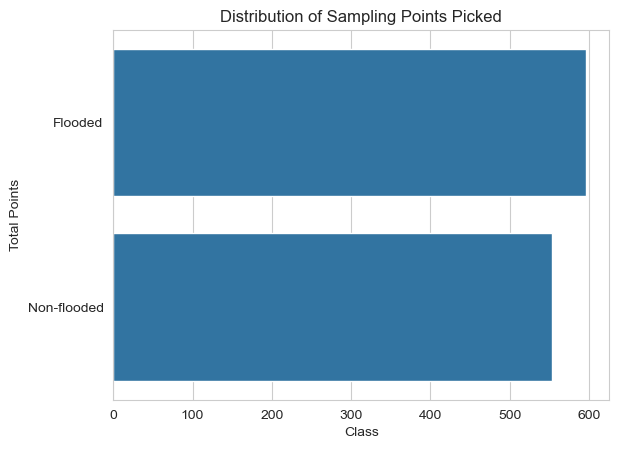

In [15]:
# Count occurrences of each class
count = data_df['Label'].value_counts()

# Plot the distribution
sns.barplot(x=count,y=['Flooded',"Non-flooded"])
plt.xlabel("Class")
plt.ylabel("Total Points")
plt.title("Distribution of Sampling Points Picked")
plt.savefig(os.path.join(CHARTS_OUTPUT,"sampling_dist"))
plt.show()

Correlation Analysis

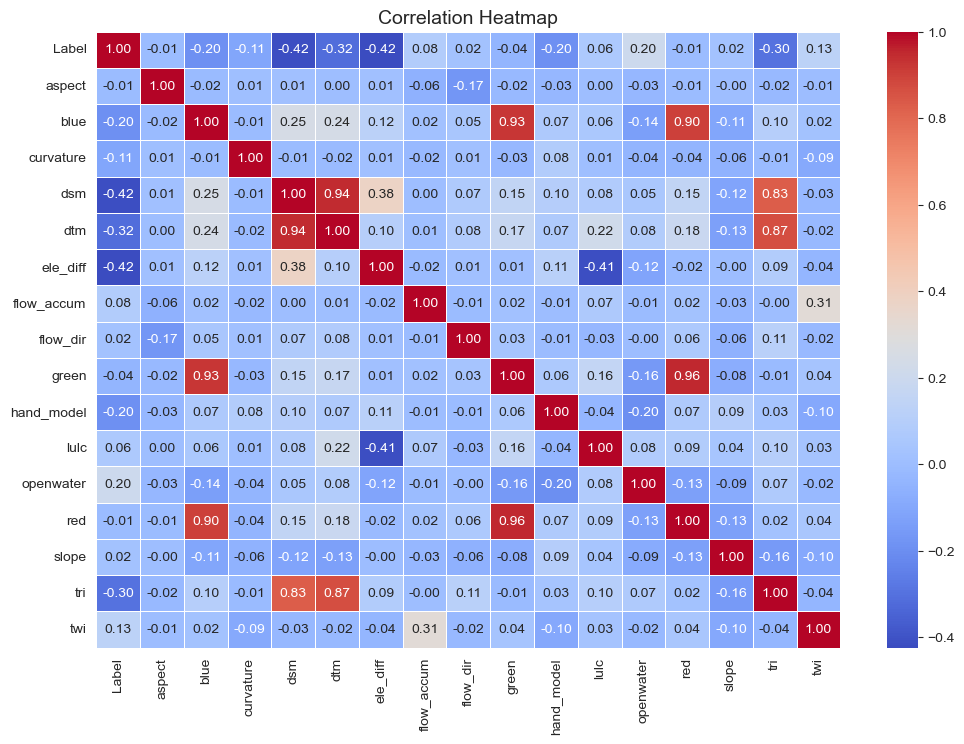

In [16]:
# Compute correlation matrix
cor = data_df.corr()
# Set figure size
plt.figure(figsize=(12, 8))  # Adjust width and height as needed
# Create heatmap with annotations
sns.heatmap(cor, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True)
# Add title
plt.title("Correlation Heatmap", fontsize=14)
# Display the plot

plt.savefig(os.path.join(CHARTS_OUTPUT,"flood corelation matrix"))
plt.show()



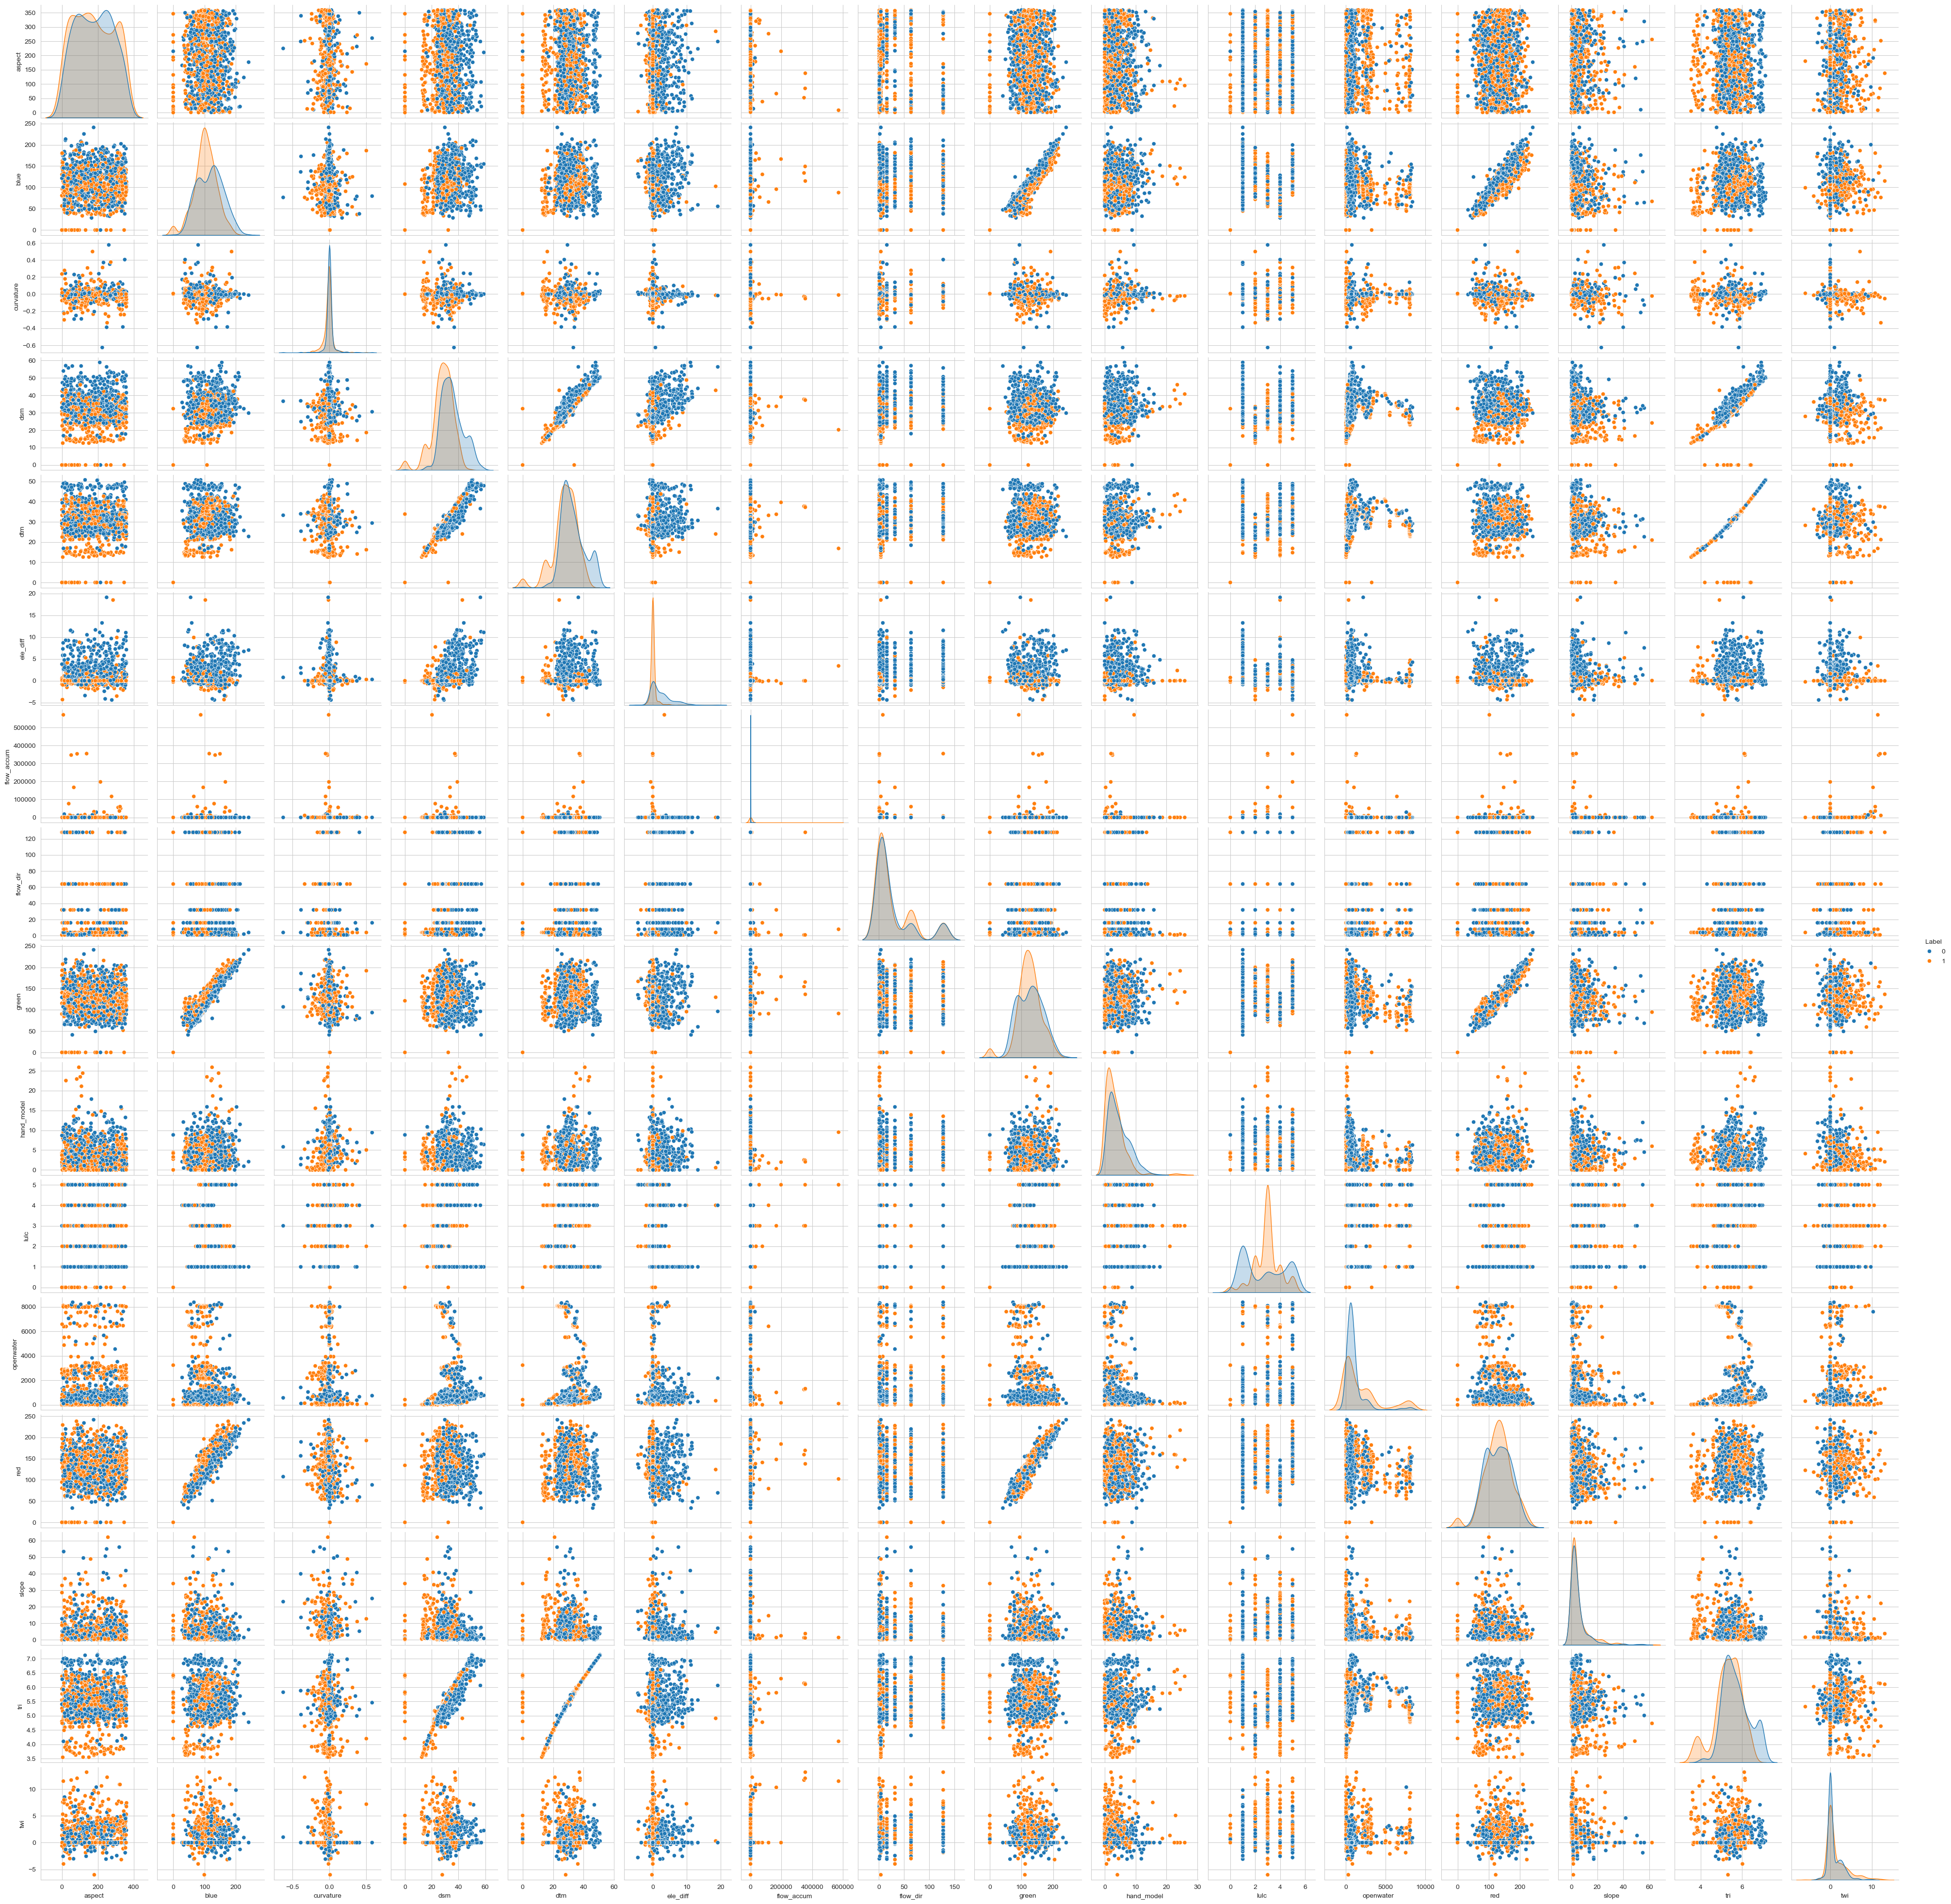

In [17]:
# Select only numeric columns and 'Label'
cols_to_plot = [col for col in data_df.columns if col != 'Label' and data_df[col].dtype != 'object']
pairplot_df = data_df[cols_to_plot + ['Label']]

# Create the pairplot
plot = sns.pairplot(pairplot_df, hue='Label')

# Save the figure
plot.fig.savefig(os.path.join(CHARTS_OUTPUT,"flood corelation matrix"))

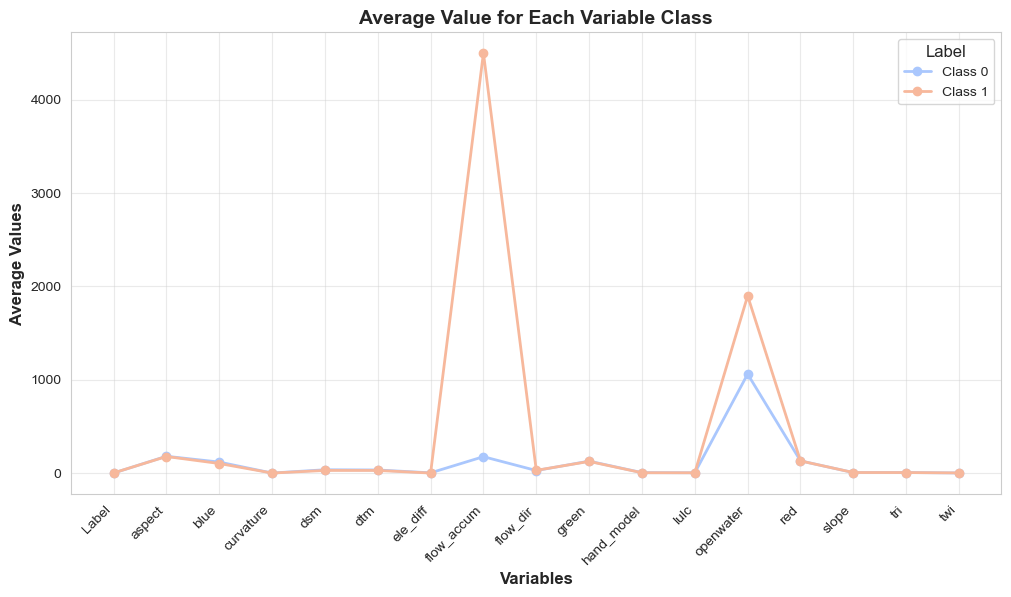

In [18]:
# Define variables
columns = list(data_df.columns)
unique_classes = sorted(data_df["Label"].unique())

# Set up the figure
plt.figure(figsize=(12, 6))  # Increased figure size for clarity

# Generate color palette
colors = sns.color_palette("coolwarm", n_colors=len(unique_classes))

# Loop through each class code and plot its average values
for class_code, color in zip(unique_classes, colors):
    class_df = data_df[data_df["Label"] == class_code]
    mean_values = class_df[columns].mean().values  # Compute mean for all variables
    
    plt.plot(
        columns,
        mean_values,
        marker="o",
        linestyle="-",
        color=color,
        markersize=6,  # Increase marker size
        linewidth=2,  # Increase line thickness
        label=f"Class {class_code}",
    )

# Plot formatting
plt.xlabel("Variables", fontsize=12, fontweight="bold")
plt.ylabel("Average Values", fontsize=12, fontweight="bold")
plt.title("Average Value for Each Variable Class", fontsize=14, fontweight="bold")

plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.legend(title="Label", fontsize=10, title_fontsize="12")
plt.grid(alpha=0.4)  # Lighter grid for aesthetics

# Show the plot
plt.show()

### Boxplots for Outliers Detection

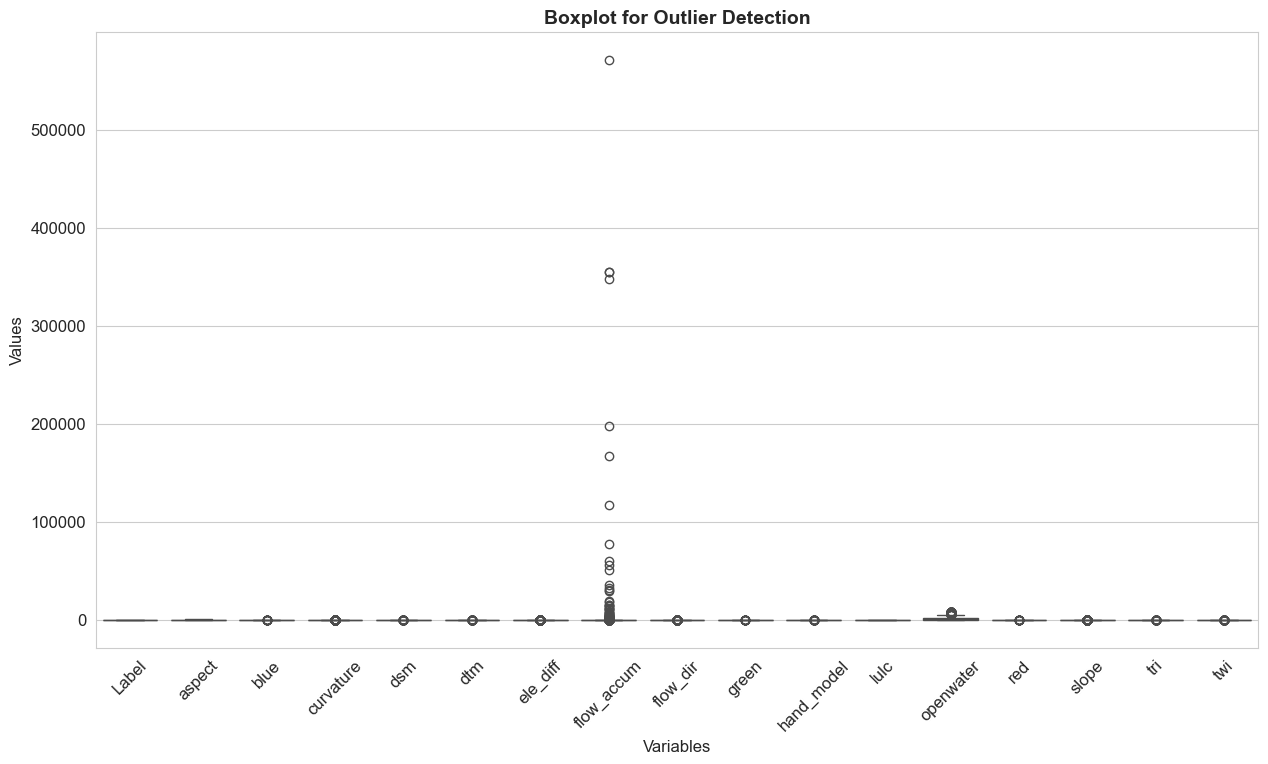

In [19]:
# Set style for better aesthetics
sns.set_style("whitegrid")

# Define figure size
plt.figure(figsize=(15, 8))
# Create boxplot
sns.boxplot(data=data_df, palette="coolwarm")
# Formatting
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Boxplot for Outlier Detection", fontsize=14, fontweight="bold")
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Values", fontsize=12)
# Show plot
plt.show()

In [20]:
# Define function to detect outliers using IQR
def detect_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1  # Interquartile range

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Boolean mask for outliers
    outliers = (df < lower_bound) | (df > upper_bound)

    return outliers

# Apply function to detect outliers
outliers = detect_outliers_iqr(data_df)
outliers.sum()  # Count of outliers per column

Label           0
aspect          0
blue           19
curvature     216
dsm            48
dtm            59
ele_diff      129
flow_accum    192
flow_dir      117
green          19
hand_model     36
lulc            0
openwater     104
red            17
slope         130
tri            50
twi            71
dtype: int64

In [21]:
##Relationship Between Elevation (dsm, dtm) and Label

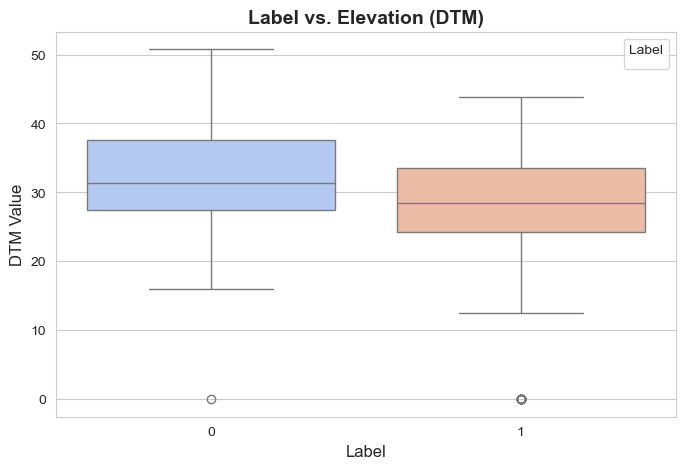

In [22]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=data_df["Label"], y=data_df["dtm"], palette="coolwarm")

# Adding labels and title with styling
plt.title("Label vs. Elevation (DTM)", fontsize=14, fontweight="bold")
plt.xlabel("Label", fontsize=12)
plt.ylabel("DTM Value", fontsize=12)

# Adding a legend (Label categories)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title="Label", loc="upper right", fontsize=10)

plt.show()


## Split data into Train and Val set

In [23]:
feature = 'Label'
X = data_df.drop(feature,axis=1)
y = data_df[feature]

X_train,X_val, y_train,y_val = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42)

## Modelling

## Build Random Forest Classifier

Baseline Model

In [24]:
def train_model(X_train, y_train):
    """ Trains a random forest model."""
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model

baseline_model = train_model(X_train, y_train)

### Evaluate Baseline Model

In [25]:
def validation_model(X_validation, y_validation, model):
    """ Validates the model."""
    y_pred = model.predict(X_validation)

    print("Baseline Classification Report")
    report = classification_report(y_validation, y_pred)
    return report

#validation report
report = validation_model(X_val, y_val, baseline_model)
print(report)

Baseline Classification Report
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       110
           1       0.83      0.92      0.87       120

    accuracy                           0.86       230
   macro avg       0.87      0.86      0.86       230
weighted avg       0.86      0.86      0.86       230



### Hyperparameter Tunning

In [26]:
rf_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)

In [27]:
params = {
    'randomforestclassifier__n_estimators': [25,20,25],
    'randomforestclassifier__max_depth': range(10,50,10)
}

In [28]:
from sklearn.model_selection import GridSearchCV

rf_model = GridSearchCV(
    rf_pipeline,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1,
)
rf_model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': [25, 20, 25]},
             verbose=1)

In [29]:
# train the model
rf_model.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': [25, 20, 25]},
             verbose=1)

In [30]:
rf_cv_results = pd.DataFrame(rf_model.cv_results_).sort_values(by='rank_test_score')
rf_cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.594012      0.048224         0.049891        0.005610   
2        0.582628      0.044168         0.050353        0.007693   
3        0.574723      0.054525         0.047569        0.008903   
5        0.613278      0.007179         0.057869        0.018426   
6        0.689913      0.008887         0.047013        0.006002   
8        0.673977      0.008362         0.034617        0.005058   
9        0.577042      0.053987         0.021005        0.005545   
11       0.389040      0.010679         0.014892        0.000465   
4        0.529959      0.004517         0.042269        0.005205   
7        0.560876      0.019595         0.048680        0.012553   
10       0.381442      0.009689         0.017940        0.000951   
1        0.496633      0.047528         0.044785        0.003716   

    param_randomforestclassifier__max_depth  \
0                                        10   
2                                        10   
3                                        20   
5                                        20   
6                                        30   
8                                        30   
9                                        40   
11                                       40   
4                                        20   
7                                        30   
10                                       40   
1                                        10   

    param_randomforestclassifier__n_estimators  \
0                                           25   
2                                           25   
3                                           25   
5                                           25   
6                                           25   
8                                           25   
9                                           25   
11                                          25   
4                                           20   
7                                           20   
10                                          20   
1                                           20   

                                               params  split0_test_score  \
0   {'randomforestclassifier__max_depth': 10, 'ran...           0.858696   
2   {'randomforestclassifier__max_depth': 10, 'ran...           0.858696   
3   {'randomforestclassifier__max_depth': 20, 'ran...           0.853261   
5   {'randomforestclassifier__max_depth': 20, 'ran...           0.853261   
6   {'randomforestclassifier__max_depth': 30, 'ran...           0.853261   
8   {'randomforestclassifier__max_depth': 30, 'ran...           0.853261   
9   {'randomforestclassifier__max_depth': 40, 'ran...           0.853261   
11  {'randomforestclassifier__max_depth': 40, 'ran...           0.853261   
4   {'randomforestclassifier__max_depth': 20, 'ran...           0.858696   
7   {'randomforestclassifier__max_depth': 30, 'ran...           0.858696   
10  {'randomforestclassifier__max_depth': 40, 'ran...           0.858696   
1   {'randomforestclassifier__max_depth': 10, 'ran...           0.826087   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.896739           0.885870           0.853261   
2            0.896739           0.885870           0.853261   
3            0.875000           0.880435           0.847826   
5            0.875000           0.880435           0.847826   
6            0.875000           0.880435           0.847826   
8            0.875000           0.880435           0.847826   
9            0.875000           0.880435           0.847826   
11           0.875000           0.880435           0.847826   
4            0.869565           0.880435           0.836957   
7            0.869565           0.880435           0.836957   
10           0.869565           0.880435           0.836957   
1            0.875000           0.885870           0.847826   

    split4_test_score  mean_test_score  std_tes

In [31]:
rf_model.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 25}

In [32]:
report = validation_model(X_val, y_val, rf_model)
print(report)

Baseline Classification Report
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       110
           1       0.84      0.93      0.88       120

    accuracy                           0.87       230
   macro avg       0.87      0.87      0.87       230
weighted avg       0.87      0.87      0.87       230



In [33]:
# Compute accuracy scores
rf_acc_train = rf_model.score(X_train, y_train)
rf_acc_val = rf_model.score(X_val, y_val)

# Print the results
print(f"Random Forest Training Accuracy: {rf_acc_train:.4f}")
print(f"Random Forest Validation Accuracy: {rf_acc_val:.4f}")

Random Forest Training Accuracy: 0.9804
Random Forest Validation Accuracy: 0.8696



Classification Report:
               precision    recall  f1-score   support

    No Label       0.91      0.81      0.86       110
       Label       0.84      0.93      0.88       120

    accuracy                           0.87       230
   macro avg       0.87      0.87      0.87       230
weighted avg       0.87      0.87      0.87       230



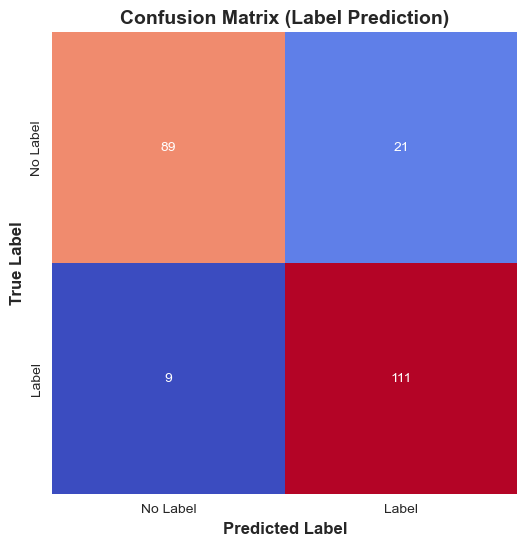

In [34]:
# Confusion Matrix of the Hypertune Model
rf_model_matix = confusion_matrix_model(X_val, y_val, rf_model)
rf_model_matix

Feature Importance Analysis

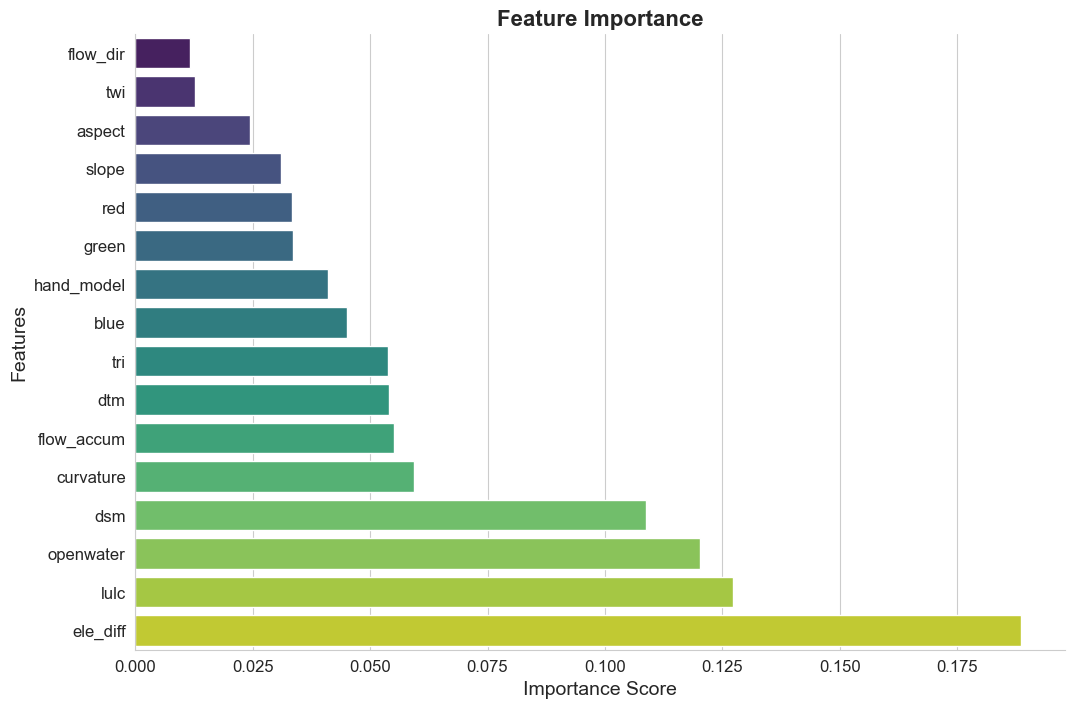

In [35]:
# Get feature names
features = X_train.columns

# Extract feature importance from the best model
rf_importances = rf_model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_

# Create a Series with feature names and importance
rf_feat_imp = pd.Series(rf_importances, index=features).sort_values()

# Create figure and axis
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=rf_feat_imp, y=rf_feat_imp.index, palette="viridis")

# Add labels and title
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title("Feature Importance", fontsize=16, fontweight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()

plt.savefig(os.path.join(CHARTS_OUTPUT,"rf_importance"))
plt.show()

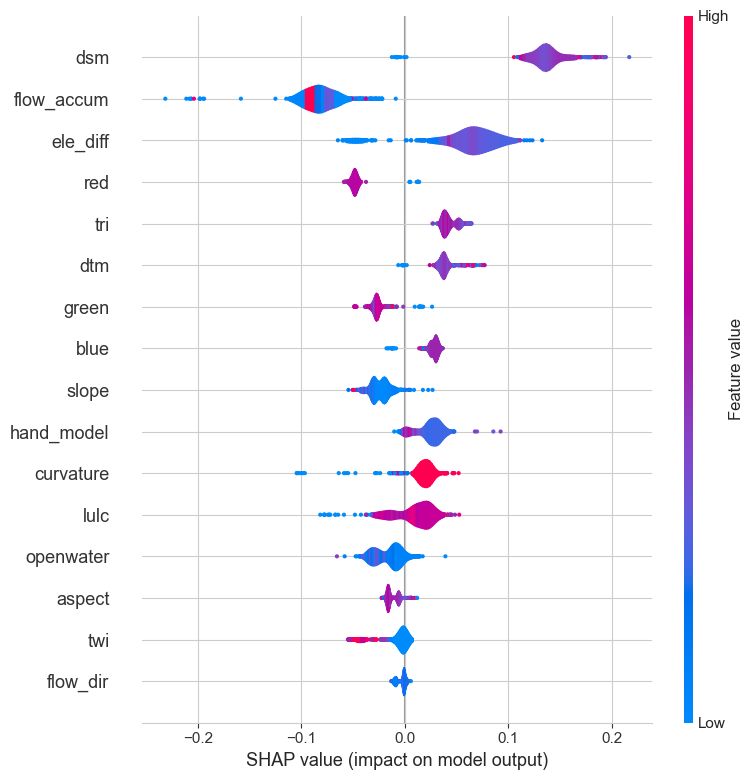

In [62]:

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf_model.best_estimator_.named_steps["randomforestclassifier"])
shap_values = explainer.shap_values(X_train)

# Select SHAP values for class 1 (positive class)
shap_df = shap_values[0]  

# Generate a violin-style SHAP summary plot
shap.summary_plot(shap_df, X_train, plot_type="violin")

In [63]:
# Create a new figure before plotting
plt.figure(figsize=(10, 6))  # Optional: adjust size

# Generate the SHAP summary plot
shap.summary_plot(shap_df, X_train, plot_type="violin", show=False)

# Save the plot
plt.savefig(os.path.join(CHARTS_OUTPUT, "rf_shap.png"), bbox_inches='tight')
plt.close()

## Supporting Vector Machine Classfier

In [37]:
# Basline model
baseline_svc_model = SVC(C=1.0, kernel='rbf', random_state=42,verbose=True)
baseline_svc_model.fit(X_train, y_train)

[LibSVM]

SVC(random_state=42, verbose=True)

In [38]:
#validation report
report = validation_model(X_val, y_val, baseline_svc_model)
print(report)

Baseline Classification Report
              precision    recall  f1-score   support

           0       0.51      0.94      0.66       110
           1       0.75      0.17      0.28       120

    accuracy                           0.54       230
   macro avg       0.63      0.56      0.47       230
weighted avg       0.64      0.54      0.46       230



In [39]:
# hyparametr tuning
# Create pipeline for SVM model with feature scaling
svc_pipeline = make_pipeline(
    StandardScaler(),  # Normalize features
    SVC(random_state=42,probability=True)
)

# Define hyperparameter grid
params = {
    'svc__C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
    'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],  # Kernel coefficient
    'svc__kernel': ['rbf']  # Kernel type
}

# Perform hyperparameter tuning with GridSearchCV
svc_model = GridSearchCV(
    svc_pipeline,
    param_grid=params,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1  # Print progress
)

svc_model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10, 100, 1000],
                         'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'svc__kernel': ['rbf']},
             verbose=1)

In [40]:
# train model
svc_model.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10, 100, 1000],
                         'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'svc__kernel': ['rbf']},
             verbose=1)

In [41]:
#validation report
svc_model_report = validation_model(X_val, y_val,svc_model)
print(svc_model_report)

Baseline Classification Report
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       110
           1       0.77      0.83      0.80       120

    accuracy                           0.78       230
   macro avg       0.78      0.78      0.78       230
weighted avg       0.78      0.78      0.78       230



In [42]:
# Best Parameters & Model Performance
print("Best Parameters:", svc_model.best_params_)
print("Best Score:", svc_model.best_score_)  # Mean cross-validation score

Best Parameters: {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best Score: 0.8380434782608696



Classification Report:
               precision    recall  f1-score   support

    No Label       0.80      0.73      0.76       110
       Label       0.77      0.83      0.80       120

    accuracy                           0.78       230
   macro avg       0.78      0.78      0.78       230
weighted avg       0.78      0.78      0.78       230



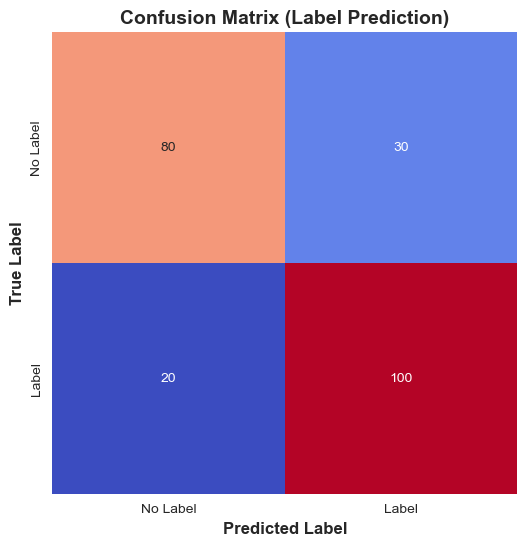

<Figure size 640x480 with 0 Axes>

In [43]:
# Call the function
svc_model_matix = confusion_matrix_model(X_val, y_val, svc_model)
svc_model_matix

plt.savefig(os.path.join(CHARTS_OUTPUT,"sv cm"))

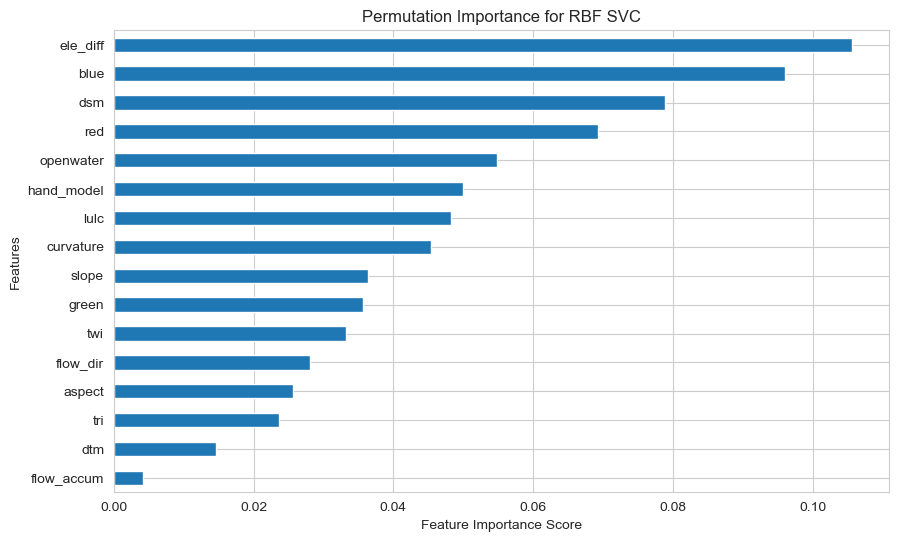

In [44]:
# Extract feature importance
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(svc_model.best_estimator_, X_train, y_train, scoring="accuracy")

# Convert to a Series for easy visualization
feature_importance = pd.Series(perm_importance.importances_mean, index=X_train.columns).sort_values()

# Plot feature importance
feature_importance.plot(kind="barh", figsize=(10, 6))
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Permutation Importance for RBF SVC")

plt.savefig(os.path.join(CHARTS_OUTPUT,"svc_importance"))
plt.show()

### Gradient Boosting Classfier

In [45]:
# Define the Gradient Boosting Classifier
baseline_gbc_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=True)

# Fit the model
baseline_gbc_model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2906            2.76s
         2           1.2128            2.37s
         3           1.1477            2.24s
         4           1.0881            2.15s
         5           1.0397            2.02s
         6           0.9971            1.90s
         7           0.9609            1.80s
         8           0.9230            1.74s
         9           0.8895            1.67s
        10           0.8641            1.62s
        20           0.6579            1.32s
        30           0.5546            1.14s
        40           0.4904            0.96s
        50           0.4400            0.79s
        60           0.3972            0.63s
        70           0.3640            0.47s
        80           0.3377            0.31s
        90           0.3132            0.15s
       100           0.2929            0.00s


GradientBoostingClassifier(random_state=42, verbose=True)

In [46]:
#validation report
report = validation_model(X_val, y_val, baseline_gbc_model)
print(report)

Baseline Classification Report
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       110
           1       0.82      0.89      0.86       120

    accuracy                           0.84       230
   macro avg       0.85      0.84      0.84       230
weighted avg       0.85      0.84      0.84       230



***Perform Hyperparameter Tunning and set cv***

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Create pipeline for Gradient Boosting Classifier
gbc_pipeline = make_pipeline(
    StandardScaler(),  # Normalize features
    GradientBoostingClassifier(random_state=42)  # GBC model
)

# Define hyperparameter grid for tuning
param_grid = {
    'gradientboostingclassifier__n_estimators': [50, 100, 200],  # Number of boosting stages
    'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'gradientboostingclassifier__max_depth': [3, 5, 7],  # Tree depth
    'gradientboostingclassifier__min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'gradientboostingclassifier__min_samples_leaf': [1, 2, 4]  # Minimum samples per leaf
}

# Perform hyperparameter tuning with GridSearchCV
gbc_model = GridSearchCV(
    gbc_pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=1  # Print progress updates
)

gbc_model 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__learning_rate': [0.01,
                                                                       0.1,
                                                                       0.2],
                         'gradientboostingclassifier__max_depth': [3, 5, 7],
                         'gradientboostingclassifier__min_samples_leaf': [1, 2,
                                                                          4],
                         'gradientboostingclassifier__min_samples_split': [2, 5,
                                                                           10],
                         'gradientboostingclassifier__n_estimators': [50, 100,
                                                                      200]},
             verbose=1)

In [48]:
# Train model
gbc_model.fit(X_train,y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__learning_rate': [0.01,
                                                                       0.1,
                                                                       0.2],
                         'gradientboostingclassifier__max_depth': [3, 5, 7],
                         'gradientboostingclassifier__min_samples_leaf': [1, 2,
                                                                          4],
                         'gradientboostingclassifier__min_samples_split': [2, 5,
                                                                           10],
                         'gradientboostingclassifier__n_estimators': [50, 100,
                                                                      200]},
             verbose=1)

In [49]:
#validation report
gbc_model_report = validation_model(X_val, y_val,gbc_model)
print(gbc_model_report)

Baseline Classification Report
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       110
           1       0.88      0.93      0.90       120

    accuracy                           0.90       230
   macro avg       0.90      0.89      0.90       230
weighted avg       0.90      0.90      0.90       230



In [50]:
# Best Parameters & Model Performance
print("Best Parameters:", gbc_model.best_params_)
print(f"Best Cross-Validation Score: {gbc_model.best_score_:.4f}")  

Best Parameters: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__min_samples_leaf': 4, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 200}
Best Cross-Validation Score: 0.8902



Classification Report:
               precision    recall  f1-score   support

    No Label       0.91      0.86      0.89       110
       Label       0.88      0.93      0.90       120

    accuracy                           0.90       230
   macro avg       0.90      0.89      0.90       230
weighted avg       0.90      0.90      0.90       230



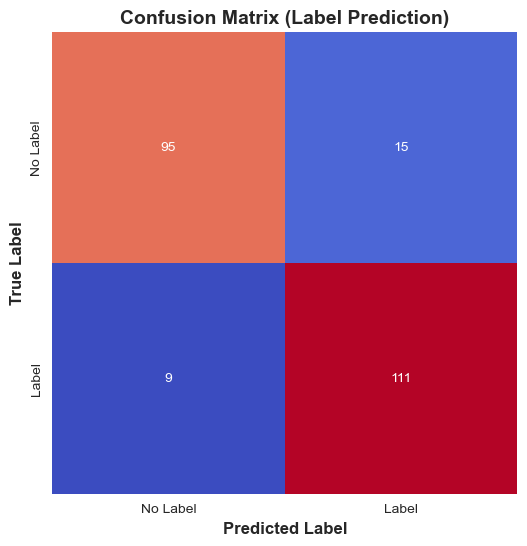

<Figure size 640x480 with 0 Axes>

In [51]:
# Call the function
gbc_model_matix = confusion_matrix_model(X_val, y_val, gbc_model)
gbc_model_matix

plt.savefig(os.path.join(CHARTS_OUTPUT,"gbc cm"))

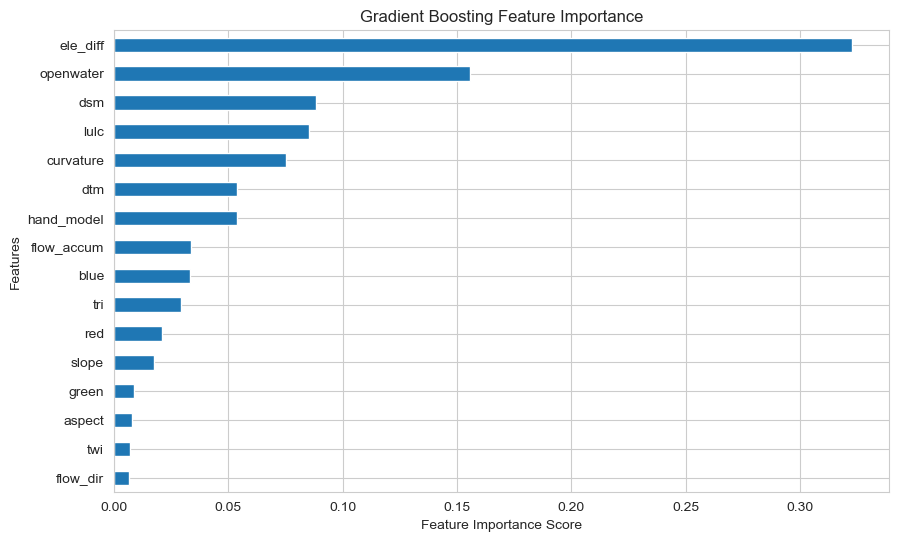

In [52]:
# Extract feature importance from Gradient Boosting Classifier
feature_importance = gbc_model.best_estimator_.named_steps["gradientboostingclassifier"].feature_importances_

# Get feature names
feature_names = X_train.columns 

# Create a Series for better visualization
importances_df = pd.Series(feature_importance, index=feature_names).sort_values()

# Plot feature importance
importances_df.plot(kind="barh", figsize=(10, 6))
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Gradient Boosting Feature Importance")

plt.savefig(os.path.join(CHARTS_OUTPUT,"gbc_import"))
plt.show()

### Compare Model Performances

In [53]:
# Generate predictions and probabilities
y_pred_rf = rf_model.predict(X_val)
y_prob_rf = rf_model.predict_proba(X_val)[:, 1]  

y_pred_svc = svc_model.predict(X_val)
y_prob_svc = svc_model.decision_function(X_val) 

y_pred_gbc = gbc_model.predict(X_val)
y_prob_gbc = gbc_model.predict_proba(X_val)[:, 1]

# Compute performance metrics
models = {
    "Random Forest": (y_pred_rf, y_prob_rf),
    "SVC": (y_pred_svc, y_prob_svc),
    "Gradient Boosting": (y_pred_gbc, y_prob_gbc)
}

metrics = []
for model_name, (y_pred, y_prob) in models.items():
    metrics.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred),
        "F1 Score": f1_score(y_val, y_pred),
        "ROC AUC": roc_auc_score(y_val, y_prob)
    })

# Convert to DataFrame for tabular representation
metrics_df = pd.DataFrame(metrics)
metrics_df

Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0      Random Forest  0.869565   0.840909  0.925000  0.880952  0.920682
1                SVC  0.782609   0.769231  0.833333  0.800000  0.879242
2  Gradient Boosting  0.895652   0.880952  0.925000  0.902439  0.952348

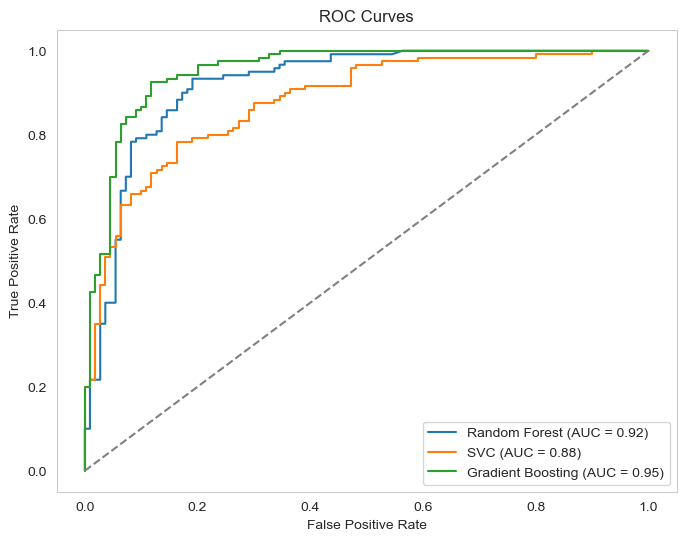

In [54]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
for model_name, (_, y_prob) in models.items():
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()

plt.savefig(os.path.join(CHARTS_OUTPUT,"roc curve flood"))
plt.grid()

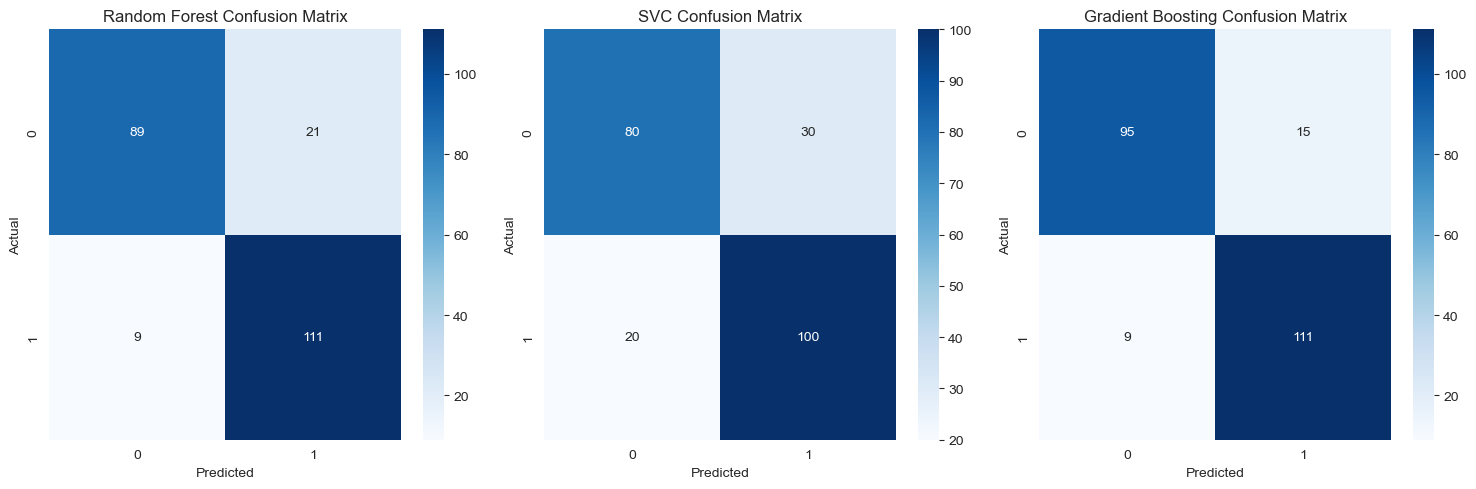

In [55]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (model_name, (y_pred, _)) in enumerate(models.items()):
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{model_name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")


plt.savefig(os.path.join(CHARTS_OUTPUT,"cm flood"))
plt.tight_layout()
plt.show()

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

# Compute additional metrics
metrics_df["AUC Loss"] = 1 - metrics_df["ROC AUC"]  # AUC Loss (1 - AUC)
metrics_df["Accuracy Loss"] = 1 - metrics_df["Accuracy"]  # Accuracy Loss
metrics_df["Kappa"] = [
    cohen_kappa_score(y_val, y_pred_rf),
    cohen_kappa_score(y_val, y_pred_svc),
    cohen_kappa_score(y_val, y_pred_gbc)
]  # Cohen's Kappa

# Define groups of metrics
performance_metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
auc_metrics = ["ROC AUC", "AUC Loss"]
error_metrics = ["Accuracy Loss", "Kappa"]

metrics_df

Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0      Random Forest  0.869565   0.840909  0.925000  0.880952  0.920682   
1                SVC  0.782609   0.769231  0.833333  0.800000  0.879242   
2  Gradient Boosting  0.895652   0.880952  0.925000  0.902439  0.952348   

   AUC Loss  Accuracy Loss     Kappa  
0  0.079318       0.130435  0.737443  
1  0.120758       0.217391  0.562738  
2  0.047652       0.104348  0.790433

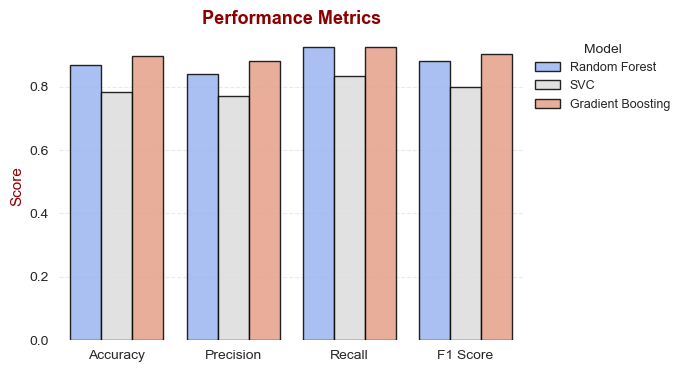

In [57]:
# Plot Performance Metrics with a different color palette
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=performance_metrics),
                 x="variable", y="value", hue="Model",
                 palette="coolwarm", edgecolor="black", alpha=0.85)

plt.title("Performance Metrics", fontsize=13, fontweight="bold", color="#8B0000")
plt.xlabel("")
plt.ylabel("Score", fontsize=11, color="#8B0000")

# Place the legend outside the plot
plt.legend(title="Model", fontsize=9, loc="upper left", bbox_to_anchor=(1, 1), frameon=False)

plt.grid(axis="y", linestyle="--", alpha=0.4)
sns.despine(left=True, bottom=True)

plt.savefig(os.path.join(CHARTS_OUTPUT,"metric_Flood.png"))
plt.show()

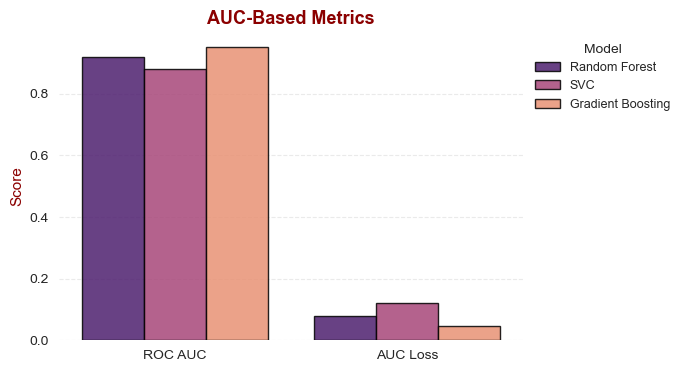

In [58]:
# Plot AUC-Based Metrics
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=auc_metrics),
                 x="variable", y="value", hue="Model",
                 palette="magma", edgecolor="black", alpha=0.85)
plt.title("AUC-Based Metrics", fontsize=13, fontweight="bold", color="#8B0000")
plt.xlabel("")
plt.ylabel("Score", fontsize=11, color="#8B0000")

# Place the legend outside the plot
plt.legend(title="Model", fontsize=9, loc="upper left", bbox_to_anchor=(1, 1), frameon=False)

plt.grid(axis="y", linestyle="--", alpha=0.4)
sns.despine(left=True, bottom=True)

plt.savefig(os.path.join(CHARTS_OUTPUT,"flood_auc_metrics.png"))
plt.show()

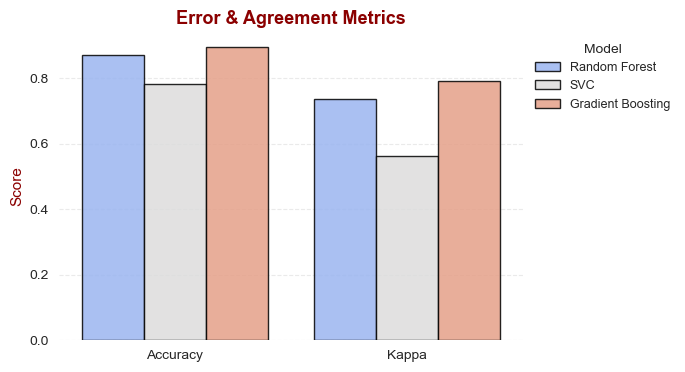

In [59]:
# Plot Error & Agreement Metrics
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Accuracy", "Kappa"]),
                 x="variable", y="value", hue="Model",
                 palette="coolwarm", edgecolor="black", alpha=0.85)

plt.title("Error & Agreement Metrics", fontsize=13, fontweight="bold", color="#8B0000")
plt.xlabel("")
plt.ylabel("Score", fontsize=11, color="#8B0000")

# Place the legend outside the plot
plt.legend(title="Model", fontsize=9, loc="upper left", bbox_to_anchor=(1, 1), frameon=False)

plt.grid(axis="y", linestyle="--", alpha=0.4)
sns.despine(left=True, bottom=True)
plt.savefig(os.path.join(CHARTS_OUTPUT,"error_flood.png"))
plt.show()

## Create Final Flood Prediction Image

In [64]:
# Load Parquet file and filter out unwanted columns
query = f"""
    SELECT * 
    FROM read_parquet('{FLOOD_PREDICTIVE_PAQ_PATH}')
"""

predictive_points_gdf = duckdb.query(query).to_df()

# Display first few rows
predictive_points_gdf.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

aspect       blue  curvature        dsm        dtm  ele_diff  \
0   76.119675  74.949997  -0.020323  27.209251  27.292253 -0.000610   
1  234.869766  77.343750  -0.094849  27.182995  27.211967 -0.003515   
2  251.640778  77.828125  -0.028900  27.345192  27.325544 -0.005638   
3  348.041534  75.484375   0.252442  27.666517  27.430872  0.002535   
4  358.553162  75.312500  -0.060337  27.399494  27.479311  0.005665   

   flow_accum  flow_dir       green  hand_model  lulc    openwater        red  \
0       205.0         1  100.216667    1.307781   2.0  6407.812988  89.099998   
1       207.0         1  101.468750    1.284430   2.0  6409.442383  92.375000   
2       209.0         1  101.546875    1.448750   2.0  6411.072266  90.515625   
3       211.0         1  100.843750    1.761902   4.0  6412.702637  85.859375   
4       213.0         1  103.687500    1.491749   4.0  6414.333008  87.187500   

      slope       tri       twi  \
0  1.439962  5.217555  3.294915   
1  3.859596  5.220508  5.467918   
2  2.795572  5.232246       NaN   
3  5.388470  5.242649       NaN   
4  6.887883  5.238132  5.730828   

                                            geometry  
0  [1, 1, 0, 0, 0, 48, 237, 13, 254, 57, 228, 17,...  
1  [1, 1, 0, 0, 0, 64, 237, 13, 254, 65, 228, 17,...  
2  [1, 1, 0, 0, 0, 64, 237, 13, 254, 73, 228, 17,...  
3  [1, 1, 0, 0, 0, 32, 237, 13, 254, 81, 228, 17,...  
4  [1, 1, 0, 0, 0, 48, 237, 13, 254, 89, 228, 17,...

In [66]:
drops_columns = ['geometry']
predictive_points = predictive_points_gdf.drop(drops_columns, axis=1)
predictive_points.columns

Index(['aspect', 'blue', 'curvature', 'dsm', 'dtm', 'ele_diff', 'flow_accum',
       'flow_dir', 'green', 'hand_model', 'lulc', 'openwater', 'red', 'slope',
       'tri', 'twi'],
      dtype='object')

In [67]:
cols = X_train.columns  # Get the columns names from X_train
X_predict = predictive_points[cols]  # Ensure correct variable name

# Replace all NaN values with 0
X_predict  = X_predict.fillna(0)

# Replace all -9999 values with 0
X_predict  = X_predict.replace(-9999, 0)

In [68]:
# probability predictions
predict_rf_proba = rf_model.predict_proba(X_predict)
predict_svc_proba = svc_model.predict_proba(X_predict)
predict_gbc_proba = gbc_model.predict_proba(X_predict)

In [69]:
predictive_points_gdf['rf'] = predict_rf_proba[:,1]
predictive_points_gdf['svc'] = predict_svc_proba[:,1]
predictive_points_gdf['gbc'] = predict_gbc_proba[:,1] 

In [70]:
predictive_points.head()

aspect       blue  curvature        dsm        dtm  ele_diff  \
0   76.119675  74.949997  -0.020323  27.209251  27.292253 -0.000610   
1  234.869766  77.343750  -0.094849  27.182995  27.211967 -0.003515   
2  251.640778  77.828125  -0.028900  27.345192  27.325544 -0.005638   
3  348.041534  75.484375   0.252442  27.666517  27.430872  0.002535   
4  358.553162  75.312500  -0.060337  27.399494  27.479311  0.005665   

   flow_accum  flow_dir       green  hand_model  lulc    openwater        red  \
0       205.0         1  100.216667    1.307781   2.0  6407.812988  89.099998   
1       207.0         1  101.468750    1.284430   2.0  6409.442383  92.375000   
2       209.0         1  101.546875    1.448750   2.0  6411.072266  90.515625   
3       211.0         1  100.843750    1.761902   4.0  6412.702637  85.859375   
4       213.0         1  103.687500    1.491749   4.0  6414.333008  87.187500   

      slope       tri       twi  
0  1.439962  5.217555  3.294915  
1  3.859596  5.220508  5.467918  
2  2.795572  5.232246       NaN  
3  5.388470  5.242649       NaN  
4  6.887883  5.238132  5.730828

In [71]:
predictive_points_gdf.head()

aspect       blue  curvature        dsm        dtm  ele_diff  \
0   76.119675  74.949997  -0.020323  27.209251  27.292253 -0.000610   
1  234.869766  77.343750  -0.094849  27.182995  27.211967 -0.003515   
2  251.640778  77.828125  -0.028900  27.345192  27.325544 -0.005638   
3  348.041534  75.484375   0.252442  27.666517  27.430872  0.002535   
4  358.553162  75.312500  -0.060337  27.399494  27.479311  0.005665   

   flow_accum  flow_dir       green  hand_model  lulc    openwater        red  \
0       205.0         1  100.216667    1.307781   2.0  6407.812988  89.099998   
1       207.0         1  101.468750    1.284430   2.0  6409.442383  92.375000   
2       209.0         1  101.546875    1.448750   2.0  6411.072266  90.515625   
3       211.0         1  100.843750    1.761902   4.0  6412.702637  85.859375   
4       213.0         1  103.687500    1.491749   4.0  6414.333008  87.187500   

      slope       tri       twi  \
0  1.439962  5.217555  3.294915   
1  3.859596  5.220508  5.467918   
2  2.795572  5.232246       NaN   
3  5.388470  5.242649       NaN   
4  6.887883  5.238132  5.730828   

                                            geometry        rf       svc  \
0  [1, 1, 0, 0, 0, 48, 237, 13, 254, 57, 228, 17,...  0.925291  0.853237   
1  [1, 1, 0, 0, 0, 64, 237, 13, 254, 65, 228, 17,...  0.889516  0.914793   
2  [1, 1, 0, 0, 0, 64, 237, 13, 254, 73, 228, 17,...  0.935291  0.968004   
3  [1, 1, 0, 0, 0, 32, 237, 13, 254, 81, 228, 17,...  0.722293  0.471584   
4  [1, 1, 0, 0, 0, 48, 237, 13, 254, 89, 228, 17,...  0.859751  0.941566   

        gbc  
0  0.999835  
1  0.999971  
2  0.999864  
3  0.996709  
4  0.999940

In [72]:
# Replace -9999 with 0
predictive_points_gdf = predictive_points_gdf.replace(-9999, 0)

# Define output file path
output_file = os.path.join(OUTPUT_DIR, "predictive_points.parquet")

# Export to Parquet
predictive_points_gdf.to_parquet(output_file, index=False)

In [74]:
import geocube
from geocube.api.core import make_geocube

rf_grid = make_geocube(
    vector_data=predictive_points_gdf,
    measurements=['rf'],
    resolution=(-1, 1),
)

svc_grid = make_geocube(
    vector_data=predictive_points_gdf,  # Ensured consistency
    measurements=['svc'],
    resolution=(-1, 1),
)

gbc_grid = make_geocube(
    vector_data=predictive_points_gdf,  # Ensured consistency
    measurements=['gbc'],
    resolution=(-1, 1),
)

# Save each grid separately
rf_grid['rf'].rasterio.to_raster("rf_FP.tif")  
svc_grid['svc'].rasterio.to_raster("svc_FP.tif")
gbc_grid['gbc'].rasterio.to_raster("gbc_FP.tif")

ImportError: cannot import name 'ImplementsArrayReduce' from partially initialized module 'xarray.core.common' (most likely due to a circular import) (C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\xarray\core\common.py)

***References***


* https://www.researchgate.net/publication/373047227_Flood_Susceptibility_Mapping_Using_Machine_Learning_Algorithms_A_Case_Study_in_Huong_Khe_District_Ha_Tinh_Province_Vietnam
* https://www.mdpi.com/2072-4292/16/12/2163
* https://www.mdpi.com/2624-6511/4/3/65

In [73]:
import os
import geopandas as gpd
import rasterio
import numpy as np
import xarray as xr
import rioxarray
from rasterio.transform import from_origin
from rasterio.features import rasterize

# Load Parquet file into a GeoDataFrame
gdf = gpd.read_parquet(os.path.join(OUTPUT_DIR, "predictive_points.parquet"))

# Ensure correct CRS
if gdf.crs is None:
    gdf.set_crs("EPSG:32632", inplace=True)  # UTM Zone 32N

# Extract bounding box coordinates
gdf["xmin"], gdf["ymin"], gdf["xmax"], gdf["ymax"] = gdf.bounds["minx"], gdf.bounds["miny"], gdf.bounds["maxx"], gdf.bounds["maxy"]

# Define grid resolution
resolution = 1  # Adjust based on your data

# Compute raster bounds
xmin, ymin, xmax, ymax = gdf.total_bounds
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Define raster transform
transform = from_origin(xmin, ymax, resolution, resolution)

# Rasterize bounding boxes using the prediction value column "rf"
shapes = [(row.geometry, row["rf"]) for _, row in gdf.iterrows()]
raster_array = rasterize(shapes, out_shape=(height, width), transform=transform, fill=0, dtype=np.float32)

# Convert to xarray
ds = xr.DataArray(
    raster_array,
    dims=("y", "x"),
    coords={
        "y": np.linspace(ymax, ymin, height, endpoint=False),
        "x": np.linspace(xmin, xmax, width, endpoint=False)
    }
)
ds.rio.write_crs("EPSG:32632", inplace=True)

# Save as GeoTIFF
ds.rio.to_raster("output_raster.tif")

print("Raster saved as output_raster.tif")

ImportError: cannot import name 'ImplementsArrayReduce' from partially initialized module 'xarray.core.common' (most likely due to a circular import) (C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\xarray\core\common.py)